<font size="+3.8">Scanpy single-cell pre-processing</font>  
<font size="+1.5"></font>  

sfrerich

Aim: Preprocess mouse brain single-cell data from Winkler 2022 Science (human adult brain - healthy controls only)  
Publication: https://pubmed.ncbi.nlm.nih.gov/35084939/

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import os
from datetime import date
from matplotlib.pyplot import rc_context

In [2]:
sc.settings.verbosity = 3

In [3]:
main_dir='/run/user/1000/gvfs/smb-share:server=138.245.4.35,share=bd-dichgans/SF' # Linux

In [4]:
main_dir='\\\isdsynnas.srv.med.uni-muenchen.de\BD-Dichgans\SF' # Win

# Load data

## Annotated 
Downloaded from: https://cells.ucsc.edu/?bp=brain&dis=Healthy~Healthy+Control&org=Human+(H.+sapiens)&ds=adult-brain-vasc

### EC dataset

In [5]:
ad = sc.read_text(main_dir+"\\P6_vasc_scRNAseq\\Winkler2022\\ucsc_cellbrowser_data\\EC\\exprMatrix.tsv.gz").transpose()
original_cellnames = ad.obs

In [6]:
meta = pd.read_csv(main_dir+"\\P6_vasc_scRNAseq\\Winkler2022\\ucsc_cellbrowser_data\\EC\\meta.tsv", sep="\t")
ad.obs = meta
ad

AnnData object with n_obs × n_vars = 5018 × 29492
    obs: 'Cell', 'orig.ident', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'Sample', 'nCount_combined', 'nFeature_combined', 'percent.mt', 'doublet2', 'doublet3', 'softmax', 'nCount_SCT', 'nFeature_SCT', 'clusters', 'Art_UCell', 'Cap_UCell', 'Venous_UCell', 'Venule_UCell', 'Cluster'

In [7]:
ad.obs.columns

Index(['Cell', 'orig.ident', 'nCount_spliced', 'nFeature_spliced',
       'nCount_unspliced', 'nFeature_unspliced', 'Sample', 'nCount_combined',
       'nFeature_combined', 'percent.mt', 'doublet2', 'doublet3', 'softmax',
       'nCount_SCT', 'nFeature_SCT', 'clusters', 'Art_UCell', 'Cap_UCell',
       'Venous_UCell', 'Venule_UCell', 'Cluster'],
      dtype='object')

In [8]:
ad.obs.head(2)

,Cell,orig.ident,nCount_spliced,nFeature_spliced,nCount_unspliced,nFeature_unspliced,Sample,nCount_combined,nFeature_combined,percent.mt,...,doublet3,softmax,nCount_SCT,nFeature_SCT,clusters,Art_UCell,Cap_UCell,Venous_UCell,Venule_UCell,Cluster
0,GGTGTCGTCAACTGAC_9,ctrl085_L,38258.9096,5725,23647.0904,5208,CTRL085,61906.0,8533,8.001521,...,Singlet,0.022721,5530,2441,Venous,0.348467,0.291344,0.824233,0.095844,Venous
1,TCATTCAAGACGCTCC_9,ctrl085_L,43172.4200,6623,25432.5800,5587,CTRL085,68605.0,9549,8.604769,...,Singlet,0.006188,5127,2498,Art1,0.701656,0.210244,0.223356,0.061833,Art1


In [9]:
assert(all(ad.obs["Cell"] == original_cellnames.index))

In [10]:
ad.obs["Sample"].unique()

array(['CTRL085', 'CTRL086', 'CTRL099_21', 'CTRL099_22', 'CTRL12'],
      dtype=object)

In [11]:
# add umap coords
umap = pd.read_csv(main_dir+"\\P6_vasc_scRNAseq\\Winkler2022\\ucsc_cellbrowser_data\\EC\\Seurat_umap.coords.tsv.gz", sep="\t", header=None)
ad.obsm['X_umap'] = umap[[1,2]].to_numpy()

In [12]:
ad = ad[(ad.obs.doublet2 != 'Doublet') & (ad.obs.doublet3 != 'Doublet')] # remove doublets

In [13]:
del ad.obs['clusters']

In [14]:
ad.obs['Cluster']

0       Venous
1         Art1
2       Venous
3       Venous
4       Venous
         ...  
5013       Cap
5014    Venule
5015      Art2
5016    Venule
5017       Cap
Name: Cluster, Length: 4950, dtype: object

In [15]:
ad.obs["clusters2"] = 'ECs_' + ad.obs['Cluster'].astype(str)

C:\Users\sfrerich\AppData\Local\Temp\ipykernel_6404\950043674.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs["clusters2"] = 'ECs_' + ad.obs['Cluster'].astype(str)
D:\Programme\Anaconda\envs\squidpy\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [16]:
ad.obs["clusters2"] = 'ECs_' + ad.obs['Cluster'].astype(str)

In [17]:
ad.obs['clusters2'].unique()

array(['ECs_Venous', 'ECs_Art1', 'ECs_Art3', 'ECs_Cap', 'ECs_Art2',
       'ECs_Venule'], dtype=object)

In [18]:
# merge subclusters
new_names = {
    'ECs_Arterial': {'ECs_Art1','ECs_Art2','ECs_Art3'},
    'ECs_Capillary': {'ECs_Cap'},
    'ECs_Venous': {'ECs_Venous','ECs_Venule'},
    'Pericytes': {'PC'},
    'SMCs': {'aSMC','aaSMC','vSMC'},
    'Oligos': {'OL'},
    'Fibroblasts': {'FB1', 'FB2'},
    'Microglia': {'MG'},
    'Astrocytes': {'AC'}
}
# re-format
result = {}
for key, value in new_names.items():
    for elem in value:
        result[(elem)] = key
new_cluster_names = dict(sorted(result.items()))
print(new_cluster_names)

{'AC': 'Astrocytes', 'ECs_Art1': 'ECs_Arterial', 'ECs_Art2': 'ECs_Arterial', 'ECs_Art3': 'ECs_Arterial', 'ECs_Cap': 'ECs_Capillary', 'ECs_Venous': 'ECs_Venous', 'ECs_Venule': 'ECs_Venous', 'FB1': 'Fibroblasts', 'FB2': 'Fibroblasts', 'MG': 'Microglia', 'OL': 'Oligos', 'PC': 'Pericytes', 'aSMC': 'SMCs', 'aaSMC': 'SMCs', 'vSMC': 'SMCs'}


In [19]:
# fine annotation
ad.obs['clusters2'] = (
    ad.obs['clusters2']
    .map(new_cluster_names)
    .astype('category')
)

In [20]:
ad.obs['clusters2'].unique()

['ECs_Venous', 'ECs_Arterial', 'ECs_Capillary']
Categories (3, object): ['ECs_Arterial', 'ECs_Capillary', 'ECs_Venous']

In [21]:
ad.obs['clusters'] = "ECs"

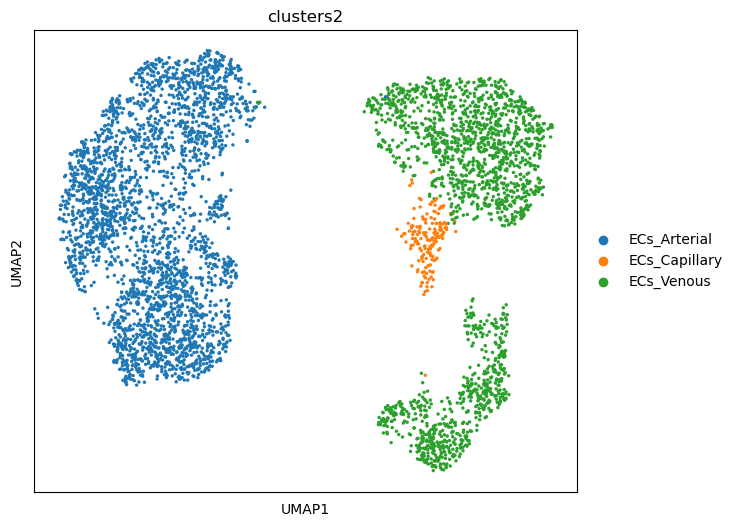

In [22]:
with rc_context({'figure.figsize': (7, 6)}):
    sc.pl.umap(ad, color=['clusters2'])

Check if data is normalized:

In [23]:
ad.layers

Layers with keys: 

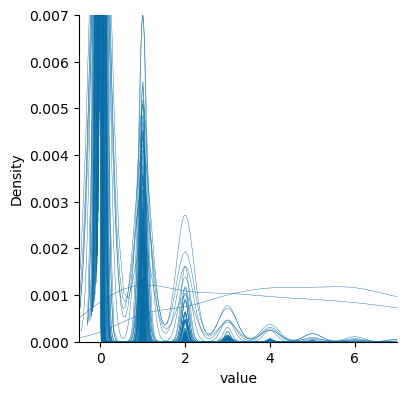

In [24]:
# show expression of 100 random genes (across all spots)
import random
import seaborn as sns
random_genes=random.sample(range(0, ad.X.shape[1]), 100)
adata_sub = ad[:,random_genes]
exp=pd.DataFrame(np.matrix(adata_sub.X))
# plot
pl1=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3) # genes with 0 expression are excluded
pl1.set(xlim=(-0.5, 7),ylim=(0,0.007));
plt.show()

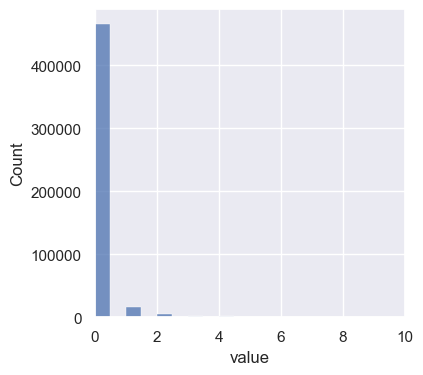

In [25]:
sns.set(rc={'figure.figsize':(4,4)})
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))
pl.set(xlim=(0, 10));
sns.set_style("ticks")
plt.show()

Data is not normalized, therefore normalize and log-transform

In [26]:
ad.layers["counts"] = ad.X.copy() # save unnormalized raw RNA counts - retrieve via ad.X = ad.layers["counts"]

In [27]:
sc.pp.normalize_total(ad, inplace=True) # Normalize each spot by total counts over all genes, so that every spot has the same total count after normalization.

normalizing counts per cell
    finished (0:00:00)


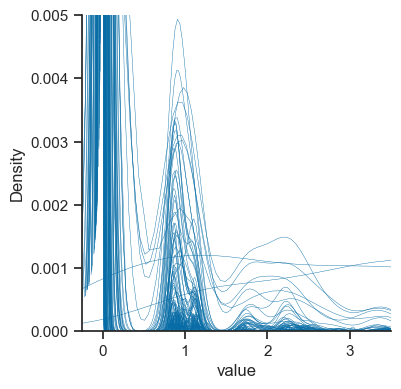

In [28]:
# show expression of 100 random genes (across all spots)
adata_sub = ad[:,random_genes]
exp=pd.DataFrame(np.matrix(adata_sub.X))
# plot
pl=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3) # genes with 0 expression are excluded
pl.set(xlim=(-0.25, 3.5),ylim=(0,0.005))
plt.show()

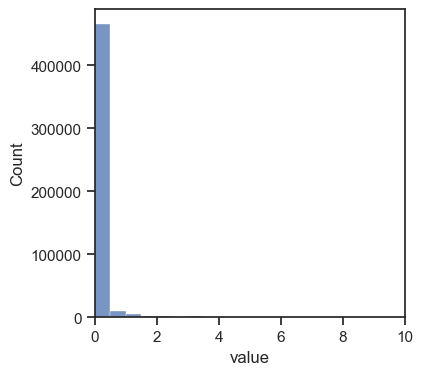

In [29]:
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))
pl.set(xlim=(0, 10))
plt.show()

In [30]:
sc.pp.log1p(ad) # X = log(X + 1)

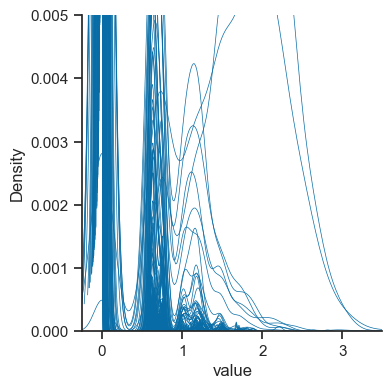

In [31]:
# show expression of 100 random genes (across all spots)
adata_sub = ad[:,random_genes]
exp=pd.DataFrame(np.matrix(adata_sub.X))
# plot
pl=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.5) # genes with 0 expression are excluded
pl.set(xlim=(-0.25, 3.5),ylim=(0,0.005));
plt.show()

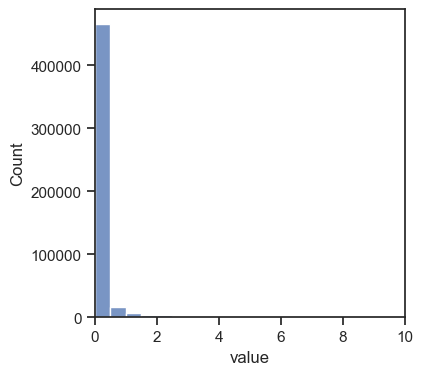

In [32]:
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)));
pl.set(xlim=(0, 10));
plt.show()

In [33]:
ad.layers["normalized"] = ad.X.copy() # save normalized + log-transformed (but unscaled) counts - retrieve via adata.X = adata.layers["normalized"]

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


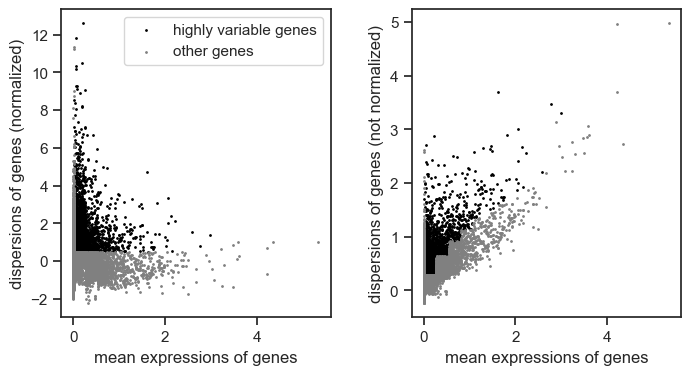

In [34]:
# Identify highly-variable genes
sc.pp.highly_variable_genes(ad)
sc.pl.highly_variable_genes(ad)

In [35]:
ad

AnnData object with n_obs × n_vars = 4950 × 29492
    obs: 'Cell', 'orig.ident', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'Sample', 'nCount_combined', 'nFeature_combined', 'percent.mt', 'doublet2', 'doublet3', 'softmax', 'nCount_SCT', 'nFeature_SCT', 'Art_UCell', 'Cap_UCell', 'Venous_UCell', 'Venule_UCell', 'Cluster', 'clusters2', 'clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters2_colors', 'log1p', 'hvg'
    obsm: 'X_umap'
    layers: 'counts', 'normalized'

In [36]:
ad.layers

Layers with keys: counts, normalized

In [37]:
winkler_ec = ad

In [38]:
del ad

### Perivascular dataset

In [39]:
ad = sc.read_text(main_dir+"\\P6_vasc_scRNAseq\\Winkler2022\\ucsc_cellbrowser_data\\Perivascular\\exprMatrix.tsv.gz").transpose()
original_cellnames = ad.obs

In [40]:
meta = pd.read_csv(main_dir+"\\P6_vasc_scRNAseq\\Winkler2022\\ucsc_cellbrowser_data\\Perivascular\\meta.tsv", sep="\t")
ad.obs = meta
ad

AnnData object with n_obs × n_vars = 49553 × 36138
    obs: 'cellId', 'orig.ident', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'Sample', 'nCount_combined', 'nFeature_combined', 'percent.mt', 'softmax', 'nCount_SCT', 'nFeature_SCT', 'clusters', 'FBMC_score', 'SMC_score', 'FB_score', 'PC_score', 'sub_clusters'

In [41]:
ad.obs.columns

Index(['cellId', 'orig.ident', 'nCount_spliced', 'nFeature_spliced',
       'nCount_unspliced', 'nFeature_unspliced', 'Sample', 'nCount_combined',
       'nFeature_combined', 'percent.mt', 'softmax', 'nCount_SCT',
       'nFeature_SCT', 'clusters', 'FBMC_score', 'SMC_score', 'FB_score',
       'PC_score', 'sub_clusters'],
      dtype='object')

In [42]:
ad.obs.head(2)

,cellId,orig.ident,nCount_spliced,nFeature_spliced,nCount_unspliced,nFeature_unspliced,Sample,nCount_combined,nFeature_combined,percent.mt,softmax,nCount_SCT,nFeature_SCT,clusters,FBMC_score,SMC_score,FB_score,PC_score,sub_clusters
0,GCGTGCACAATCCTTT_9,ctrl085_L,45786.477119,6851,18618.522899,5258,CTRL085,64405.000018,9527,8.891061,0.003459,5009,2365,FBMC,0.853494,-0.115504,0.312556,0.014801,FBMC2
1,TCGGTCTCACATAACC_9,ctrl085_L,58604.482805,7658,22669.517186,5735,CTRL085,81273.999990,10382,8.676364,0.006037,5001,2388,FBMC,1.030248,0.097485,0.466670,0.020408,FBMC2


In [43]:
assert(all(ad.obs["cellId"] == original_cellnames.index))

In [44]:
ad.obs["Sample"].unique()

array(['CTRL085', 'CTRL086', 'CTRL099_21', 'CTRL099_22', 'CTRL12'],
      dtype=object)

In [45]:
# add umap coords
umap = pd.read_csv(main_dir+"\\P6_vasc_scRNAseq\\Winkler2022\\ucsc_cellbrowser_data\\Perivascular\\UMAP.coords.tsv.gz", sep="\t", header=None)
ad.obsm['X_umap'] = umap[[1,2]].to_numpy()

In [46]:
#ad = ad[(ad.obs.doublet2 != 'Doublet') & (ad.obs.doublet3 != 'Doublet')] # remove doublets

In [47]:
# Renaming
old_to_new = {'FB':'Fibroblasts','FBMC':'Fibromyocytes','PC':'Pericytes','SMC':'SMCs'}
ad.obs['clusters2'] = (
    ad.obs['clusters'].map(old_to_new).astype('category')
)

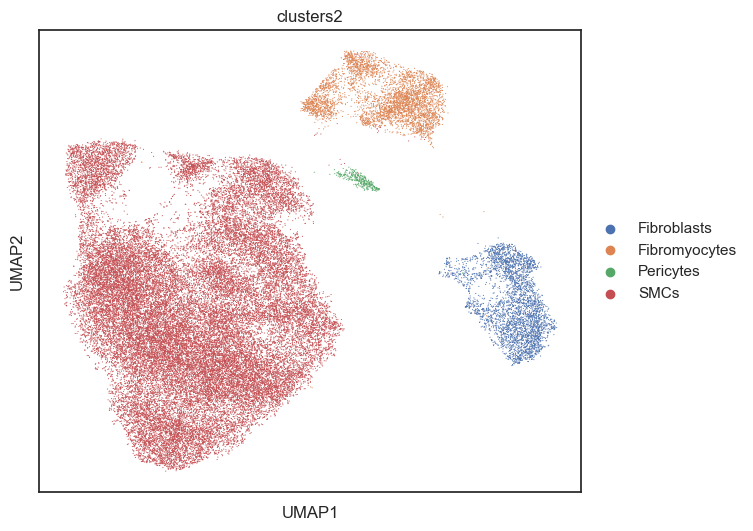

In [48]:
with rc_context({'figure.figsize': (7, 6)}):
    sc.pl.umap(ad, color=['clusters2'])

Check if data is normalized:

In [49]:
ad.layers

Layers with keys: 

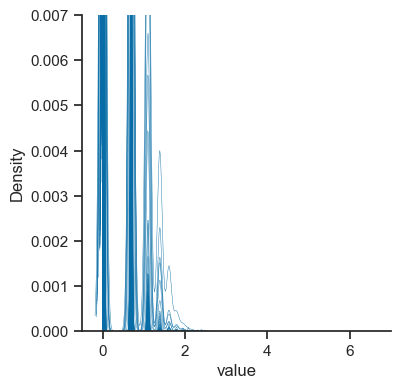

In [50]:
# show expression of 100 random genes (across all spots)
import random
import seaborn as sns
random_genes=random.sample(range(0, ad.X.shape[1]), 100)
adata_sub = ad[:,random_genes]
exp=pd.DataFrame(np.matrix(adata_sub.X))
# plot
pl1=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3) # genes with 0 expression are excluded
pl1.set(xlim=(-0.5, 7),ylim=(0,0.007));
sns.set_style("ticks")
plt.show()

In [51]:
exp.iloc[0:5,0:30]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Note: Matrix is apparently log-transformed. Also see https://github.com/cnk113/vascular-analysis/issues/1.

In [52]:
# reverse log-transformation ln(x+1)
import math
ad.layers["counts"] = (math.e**(ad.X))-1

In [53]:
ad.layers["log?"] = ad.X

In [54]:
ad.X = ad.layers["counts"]

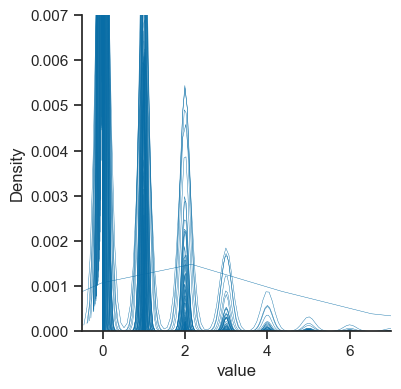

In [55]:
# show expression of 100 random genes (across all spots)
import random
import seaborn as sns
random_genes=random.sample(range(0, ad.X.shape[1]), 100)
adata_sub = ad[:,random_genes]
exp=pd.DataFrame(np.matrix(adata_sub.X))
# plot
pl1=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3) # genes with 0 expression are excluded
pl1.set(xlim=(-0.5, 7),ylim=(0,0.007));
plt.show()

In [56]:
exp.iloc[0:5,0:20]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


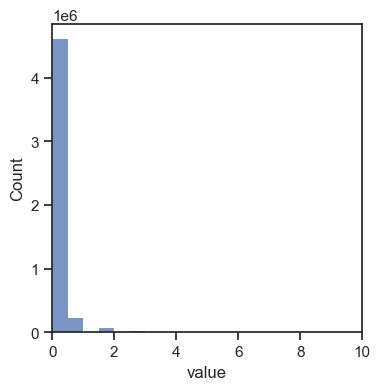

In [57]:
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)));
pl.set(xlim=(0, 10));
plt.show()

Now normalize and log-transform

In [58]:
ad.layers["counts"] = ad.X.copy() # save unnormalized raw RNA counts - retrieve via ad.X = ad.layers["counts"]

In [59]:
sc.pp.normalize_total(ad, inplace=True) # Normalize each cell by total counts over all genes, so that every cell has the same total count after normalization.

normalizing counts per cell
    finished (0:00:00)


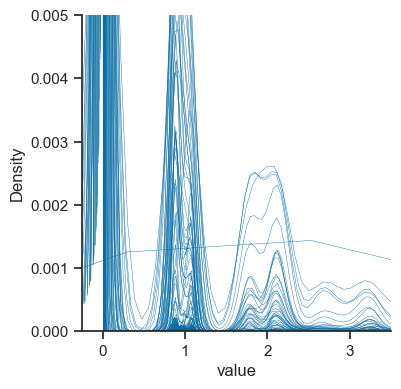

In [60]:
# show expression of 100 random genes (across all spots)
adata_sub = ad[:,random_genes]
exp=pd.DataFrame(np.matrix(adata_sub.X))
# plot
pl=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3) # genes with 0 expression are excluded
pl.set(xlim=(-0.25, 3.5),ylim=(0,0.005))
sns.set_style("ticks")
plt.show()

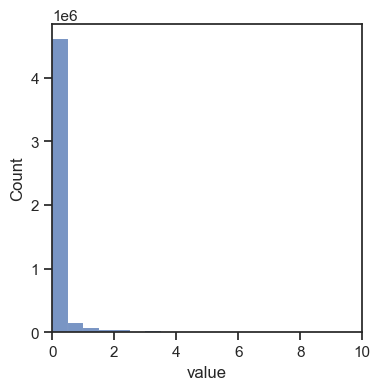

In [61]:
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))
pl.set(xlim=(0, 10))
sns.set_style("ticks")
plt.show()

In [62]:
sc.pp.log1p(ad) # X = log(X + 1)

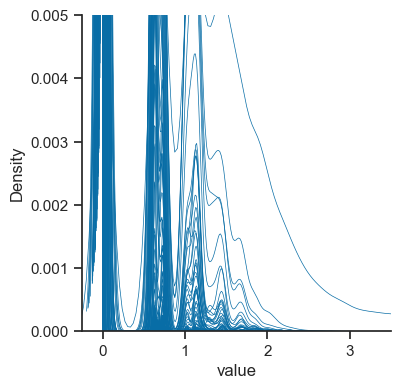

In [63]:
# show expression of 100 random genes (across all spots)
adata_sub = ad[:,random_genes]
exp=pd.DataFrame(np.matrix(adata_sub.X))
# plot
pl=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.5) # genes with 0 expression are excluded
pl.set(xlim=(-0.25, 3.5),ylim=(0,0.005));
plt.show()

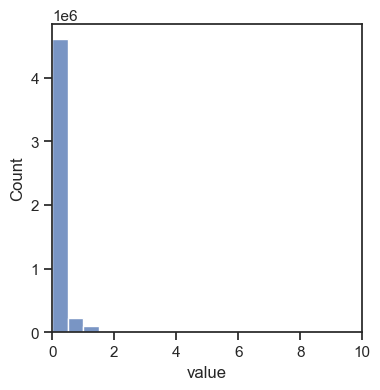

In [64]:
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)));
pl.set(xlim=(0, 10));
plt.show()

In [65]:
ad.layers["normalized"] = ad.X.copy() # save normalized + log-transformed (but unscaled) counts - retrieve via adata.X = adata.layers["normalized"]

In [ ]:
# Identify highly-variable genes
sc.pp.highly_variable_genes(ad)
sc.pl.highly_variable_genes(ad)

In [71]:
ad

AnnData object with n_obs × n_vars = 49553 × 36138
    obs: 'cellId', 'orig.ident', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'Sample', 'nCount_combined', 'nFeature_combined', 'percent.mt', 'softmax', 'nCount_SCT', 'nFeature_SCT', 'clusters', 'FBMC_score', 'SMC_score', 'FB_score', 'PC_score', 'sub_clusters', 'clusters2'
    uns: 'clusters2_colors', 'log1p'
    obsm: 'X_umap'
    layers: 'normalized'

In [67]:
ad.layers

Layers with keys: counts, log?, normalized

In [68]:
ad.obs["clusters"] = ad.obs["clusters2"]

In [69]:
winkler_pv = ad

### Merge

In [ ]:
# free memory
del winkler_pv.layers["log?"]
del winkler_pv.layers["counts"]
del winkler_ec.layers["counts"]

In [76]:
del winkler_pv.uns
del winkler_ec.uns

In [73]:
del ad
del exp
del adata_sub
del random_genes

In [79]:
# merge winkler datasets
adata = anndata.concat([winkler_ec, winkler_pv], join="inner") # ignore batch effects etc. because dataset is pre-annotated

# Standard pipeline

Skip, because data is pre-analyzed.

# Focus on: Foxf2

In [80]:
gene="FOXF2"

## Plot

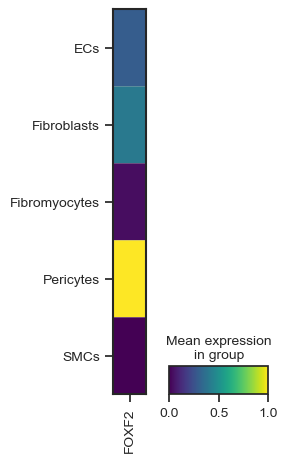

In [81]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

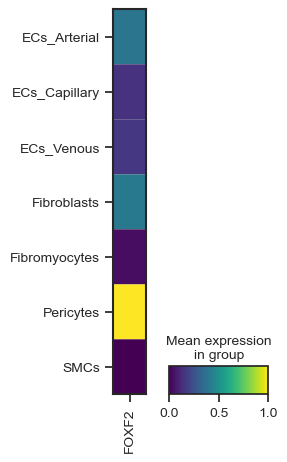

In [84]:
sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

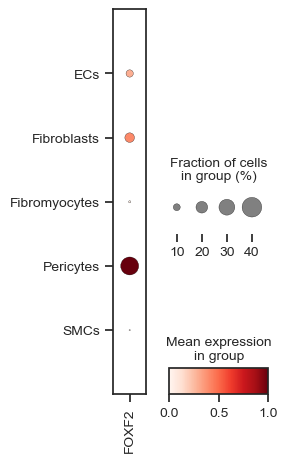

In [86]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

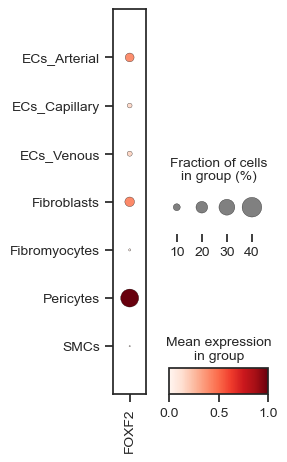

In [87]:
sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

## Excl zonation

In [88]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
ECs,0.291276
Fibroblasts,0.403376
Fibromyocytes,0.033961
Pericytes,1.000000
SMCs,0.000000


In [89]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
ECs,0.107273
Fibroblasts,0.153991
Fibromyocytes,0.021365
Pericytes,0.355623
SMCs,0.010474


In [90]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Winkler2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
ECs,0.291276,0.107273,FOXF2,Winkler2022,Human,4950
Fibroblasts,0.403376,0.153991,FOXF2,Winkler2022,Human,3721
Fibromyocytes,0.033961,0.021365,FOXF2,Winkler2022,Human,4353
Pericytes,1.000000,0.355623,FOXF2,Winkler2022,Human,329
SMCs,0.000000,0.010474,FOXF2,Winkler2022,Human,41150


In [91]:
# export
name='Winkler2022'

In [92]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Foxf2_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+name+'_normalized.csv',sep=';')

## Incl zonation

In [93]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']

In [94]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']

In [96]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Winkler2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
ECs_Arterial,0.388578,0.136868,FOXF2,Winkler2022,Human,2886
ECs_Capillary,0.143142,0.060606,FOXF2,Winkler2022,Human,165
ECs_Venous,0.156274,0.066351,FOXF2,Winkler2022,Human,1899
Fibroblasts,0.403376,0.153991,FOXF2,Winkler2022,Human,3721
Fibromyocytes,0.033961,0.021365,FOXF2,Winkler2022,Human,4353
Pericytes,1.000000,0.355623,FOXF2,Winkler2022,Human,329
SMCs,0.000000,0.010474,FOXF2,Winkler2022,Human,41150


In [97]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Foxf2_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+name+'_incl_zonation_normalized.csv',sep=';')

# Focus on: Other genes

## Foxo1

In [98]:
gene="FOXO1"

### Plot

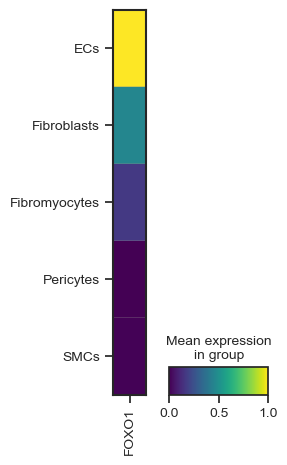

In [100]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

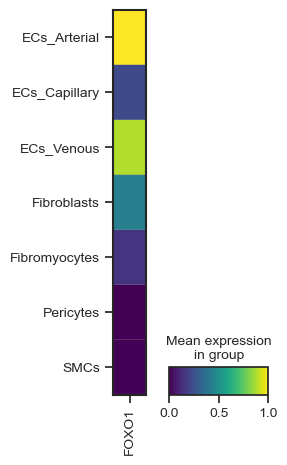

In [101]:
sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

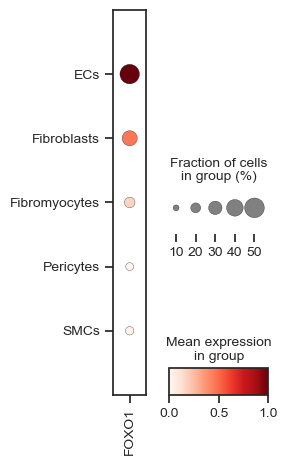

In [102]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

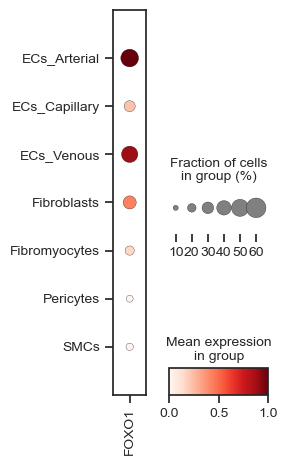

In [103]:
sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

### Excl zonation

In [104]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
ECs,1.000000
Fibroblasts,0.460878
Fibromyocytes,0.164828
Pericytes,0.000000
SMCs,0.007659


In [105]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
ECs,0.494949
Fibroblasts,0.349368
Fibromyocytes,0.218929
Pericytes,0.148936
SMCs,0.163183


In [106]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Winkler2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
ECs,1.000000,0.494949,FOXO1,Winkler2022,Human,4950
Fibroblasts,0.460878,0.349368,FOXO1,Winkler2022,Human,3721
Fibromyocytes,0.164828,0.218929,FOXO1,Winkler2022,Human,4353
Pericytes,0.000000,0.148936,FOXO1,Winkler2022,Human,329
SMCs,0.007659,0.163183,FOXO1,Winkler2022,Human,41150


In [99]:
# export
name='Winkler2022'

In [107]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

### Incl zonation

In [108]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']

In [109]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']

In [110]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Winkler2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
ECs_Arterial,1.000000,0.523216,FOXO1,Winkler2022,Human,2886
ECs_Capillary,0.225253,0.278788,FOXO1,Winkler2022,Human,165
ECs_Venous,0.883314,0.470774,FOXO1,Winkler2022,Human,1899
Fibroblasts,0.428345,0.349368,FOXO1,Winkler2022,Human,3721
Fibromyocytes,0.153193,0.218929,FOXO1,Winkler2022,Human,4353
Pericytes,0.000000,0.148936,FOXO1,Winkler2022,Human,329
SMCs,0.007118,0.163183,FOXO1,Winkler2022,Human,41150


In [111]:
# export
name='Winkler2022'

In [112]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation_normalized.csv',sep=';')

## Tek = Tie2

In [113]:
gene="TEK"

### Plot

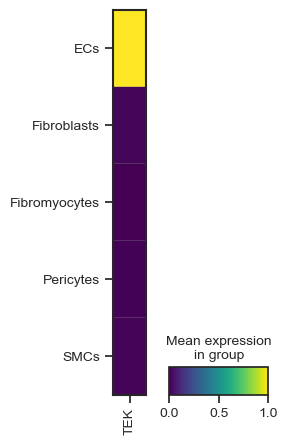

In [114]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

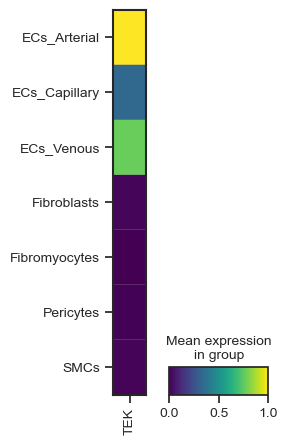

In [115]:
sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

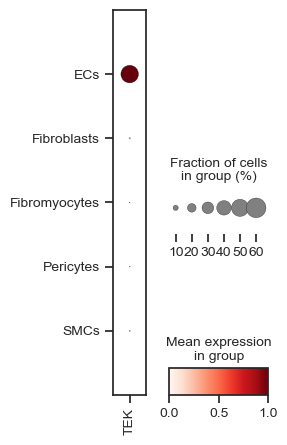

In [116]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

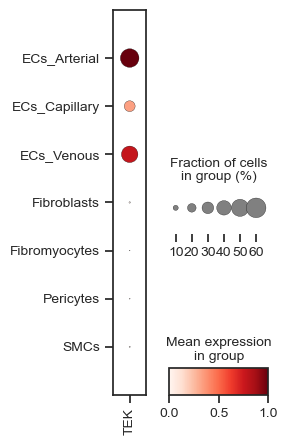

In [117]:
sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

### Excl zonation

In [118]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
ECs,1.000000
Fibroblasts,0.014975
Fibromyocytes,0.000000
Pericytes,0.007327
SMCs,0.008887


In [119]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
ECs,0.516566
Fibroblasts,0.018006
Fibromyocytes,0.006892
Pericytes,0.009119
SMCs,0.013730


In [120]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Winkler2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
ECs,1.000000,0.516566,TEK,Winkler2022,Human,4950
Fibroblasts,0.014975,0.018006,TEK,Winkler2022,Human,3721
Fibromyocytes,0.000000,0.006892,TEK,Winkler2022,Human,4353
Pericytes,0.007327,0.009119,TEK,Winkler2022,Human,329
SMCs,0.008887,0.013730,TEK,Winkler2022,Human,41150


In [121]:
# export
name='Winkler2022'

In [122]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

### Incl zonation

In [123]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']

In [124]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']

In [125]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Winkler2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
ECs_Arterial,1.000000,0.557519,TEK,Winkler2022,Human,2886
ECs_Capillary,0.335242,0.272727,TEK,Winkler2022,Human,165
ECs_Venous,0.771136,0.475513,TEK,Winkler2022,Human,1899
Fibroblasts,0.013328,0.018006,TEK,Winkler2022,Human,3721
Fibromyocytes,0.000000,0.006892,TEK,Winkler2022,Human,4353
Pericytes,0.006521,0.009119,TEK,Winkler2022,Human,329
SMCs,0.007910,0.013730,TEK,Winkler2022,Human,41150


In [126]:
# export
name='Winkler2022'

In [127]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation_normalized.csv',sep=';')

## Nos3 = eNOS

In [128]:
gene="NOS3"

### Plot

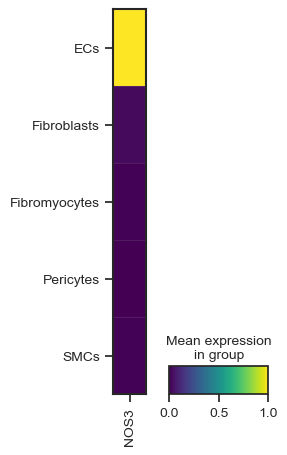

In [129]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

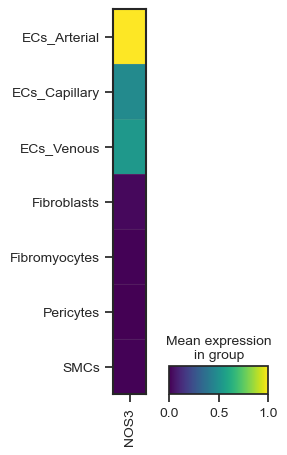

In [130]:
sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

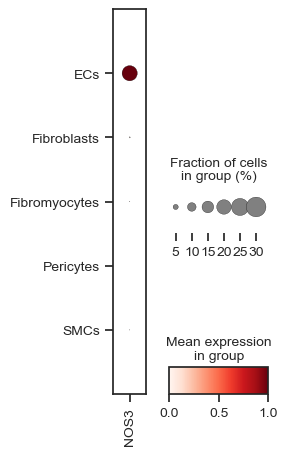

In [131]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

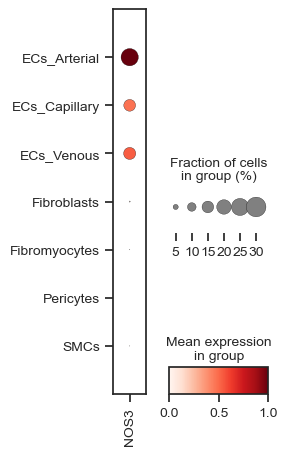

In [132]:
sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

### Excl zonation

In [133]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
ECs,1.000000
Fibroblasts,0.026624
Fibromyocytes,0.007735
Pericytes,0.000000
SMCs,0.006522


In [134]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
ECs,0.213131
Fibroblasts,0.006181
Fibromyocytes,0.001838
Pericytes,0.000000
SMCs,0.001555


In [135]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Winkler2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
ECs,1.000000,0.213131,NOS3,Winkler2022,Human,4950
Fibroblasts,0.026624,0.006181,NOS3,Winkler2022,Human,3721
Fibromyocytes,0.007735,0.001838,NOS3,Winkler2022,Human,4353
Pericytes,0.000000,0.000000,NOS3,Winkler2022,Human,329
SMCs,0.006522,0.001555,NOS3,Winkler2022,Human,41150


In [136]:
# export
name='Winkler2022'

In [137]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

### Incl zonation

In [138]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']

In [139]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']

In [140]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Winkler2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
ECs_Arterial,1.000000,0.253292,NOS3,Winkler2022,Human,2886
ECs_Capillary,0.475248,0.151515,NOS3,Winkler2022,Human,165
ECs_Venous,0.533908,0.157451,NOS3,Winkler2022,Human,1899
Fibroblasts,0.021398,0.006181,NOS3,Winkler2022,Human,3721
Fibromyocytes,0.006217,0.001838,NOS3,Winkler2022,Human,4353
Pericytes,0.000000,0.000000,NOS3,Winkler2022,Human,329
SMCs,0.005242,0.001555,NOS3,Winkler2022,Human,41150


In [141]:
# export
name='Winkler2022'

In [142]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation_normalized.csv',sep=';')

# Session Info

In [143]:
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.2.0
asciitree                   NA
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.5
cffi                        1.15.1
cloudpickle                 2.0.0
colorama                    0.4.5
cycler                      0.10.0
cython_runtime              NA
dask                        2022.05.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
fasteners                   0.17.3
fsspec                      2022.3.0
h5py                        3.6.0
hypergeom_ufunc             NA
igraph                      0.9.10
ipykernel                   6.15.2
ipython_genutils            0.2.0
ipywidgets                  7.7.0
jedi                        0.18.1
jinja2 